## <span style="color:red"> How to Build Neural Networks using Keras</span>

### Import Modules

In [2]:
import pandas as pd
import numpy as np
import os
import random
import pickle
import gc
from IPython.display import Image
import warnings; warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.11.0


### Set Random seeds to make your results reproducible

In [3]:
# 매번 모델링을 할 때마다 동일한 결과를 얻으려면 아래 코드를 실행해야 함.

def reset_seeds(reset_graph_with_backend=None):
    if reset_graph_with_backend is not None:
        K = reset_graph_with_backend
        K.clear_session()
        tf.compat.v1.reset_default_graph()
        print("KERAS AND TENSORFLOW GRAPHS RESET")  # optional

    np.random.seed(1)
    random.seed(2)
    tf.compat.v1.set_random_seed(3)
    os.environ['CUDA_VISIBLE_DEVICES'] = ''  # for GPU
    print("RANDOM SEEDS RESET")  # optional
   
reset_seeds()

RANDOM SEEDS RESET


### Step 1 : Load and Process the data

In [4]:
# Read Data
X_train = pd.read_csv('./data/X_train.csv', encoding='cp949')
y_train = pd.read_csv('./data/y_train.csv').gender
X_test = pd.read_csv('./data/X_test.csv', encoding='cp949')

# submission을 만들 때 사용하기 위해 ID 저정
ID_test = X_test.cust_id

#### Explore data

In [5]:
# 결측값 존재여부와 범주형 feature 확인
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 68 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   cust_id             3500 non-null   int64  
 1   총구매액                3500 non-null   int64  
 2   구매건수                3500 non-null   int64  
 3   평균구매액               3500 non-null   int64  
 4   최대구매액               3500 non-null   int64  
 5   구매상품종류1             3500 non-null   int64  
 6   내점일수                3500 non-null   int64  
 7   구매주기                3500 non-null   int64  
 8   봄-구매비율              3500 non-null   float64
 9   여름-구매비율             3500 non-null   float64
 10  가을-구매비율             3500 non-null   float64
 11  겨울-구매비율             3500 non-null   float64
 12  환불금액                1205 non-null   float64
 13  환불건수                1205 non-null   float64
 14  내점당구매액              3500 non-null   float64
 15  내점당구매건수             3500 non-null   float64
 16  주구매상품 

In [6]:
# 범주형 변수와 수치형 변수를 분리
cat_features = X_train.select_dtypes(include=['object']).columns.to_list()
num_features = list(set(X_train.columns) - set(cat_features))

Impute Missing Values

In [7]:
from sklearn.impute import SimpleImputer 

if len(num_features) > 0:
    imp = SimpleImputer(strategy='mean')
    X_train[num_features] = imp.fit_transform(X_train[num_features])
    X_test[num_features] = imp.transform(X_test[num_features])
if len(cat_features) > 0:  
    imp = SimpleImputer(strategy="most_frequent")
    X_train[cat_features] = imp.fit_transform(X_train[cat_features])
    X_test[cat_features] = imp.transform(X_test[cat_features])

#### Transform features (Feature Scaling)

In [9]:
# DNN 모델링에서는 StandardScaler을 주로 사용
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

#### Encode Categorical Variabels

In [11]:
df_encoded = pd.get_dummies(pd.concat([X_train, X_test]), columns=cat_features)
X_train = df_encoded[:X_train.shape[0]]
X_test = df_encoded[X_train.shape[0]:]

#### Select Features

  0%|          | 0/95 [00:00<?, ?it/s]

(46, 0.736715940840205)


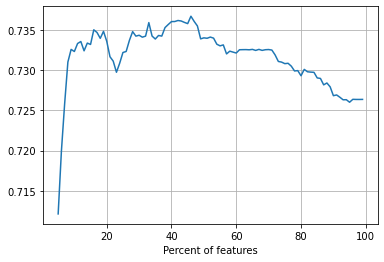

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import cross_val_score
from tqdm import tqdm, tqdm_notebook

# 사용할 모델 설정 
model = LogisticRegression(random_state=0)

# 각 특성과 타깃(class) 사이에 유의한 통계적 관계가 있는지 계산하여 특성을 선택하는 방법 
cv_scores = []
for p in tqdm_notebook(range(5,100,1)):
    X_new = SelectPercentile(percentile=p).fit_transform(X_train, y_train)    
    cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
    cv_scores.append((p,cv_score))

# Print the best percentile
best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
print(best_score)

# Plot the performance change with p
plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
plt.xlabel('Percent of features')
plt.grid()

In [14]:
fs = SelectPercentile(percentile=best_score[0]).fit(X_train, y_train)
X_train = fs.transform(X_train)
X_test = fs.transform(X_test)

print(X_train.shape)

(3500, 147)


#### Split Data into Train & Validation Set

In [16]:
# DNN은 학습과정에서 과적합여부를 확인하는 것이 매우 중요하기 때문에 
# 학습데이터를 Train/Validation 나누고 학습을 진행함.
i = int(round(X_train.shape[0] * 0.6,0))
X_valid, y_valid = X_train[i:], y_train[i:]
X_train, y_train = X_train[:i], y_train[:i]

#### Save all the preprocessed data

In [18]:
# pickle 형식으로 저장
with open('./data/preprocessed_data.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_valid, y_valid, X_test, ID_test), f)

# 추후 저장한 모형 불러올 때: 
# X_train, y_train, X_valid, y_valid, X_test, ID_test = pd.read_pickle('preprocessed_data.pkl')

### Step 2 : Define the model architecture
#### Stack layers from input to output

|모듈|사용 예 및 종류|
|---|:---:|
|Initializer| Dense(16, kernel_initializer='he_normal')|
|Regularizer| Dense(16, kernel_regularizer=l2(0.01))|
|Activation|relu / elu / selu / softmax / tanh / sigmoid / linear|

In [19]:
# Input => Dense + Dense + ... => output
# Model(input, output)

input = keras.Input(shape=(X_train.shape[1],))

In [20]:
x = keras.layers.Dense(16, activation='relu')(input)
x = keras.layers.Dense(8, activation='relu')(x)
output = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(input, output)

*Keras Sequential API*
```
model = Sequential([
  keras.layers.Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
  keras.layers.Dense(8),
  keras.layers.Dense(1, activation='sigmoid')
])
```

#### Summarize & Visualize the model

In [22]:
model.summary()
#Image(keras.utils.model_to_dot(model,show_shapes=True,show_layer_names=False, dpi=100) \
#      .create(prog='dot', format='png'))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 147)]             0         
                                                                 
 dense (Dense)               (None, 16)                2368      
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,513
Trainable params: 2,513
Non-trainable params: 0
_________________________________________________________________


### Step 3: Choose the optimizer and the cost function
<img align='left' src='http://drive.google.com/uc?export=view&id=1xybqHMvcDDfUYSN3FLQ6Y1708QkiZSJt' style="width: 70%">

*Optimizer의 예:*
- keras.optimizers.SGD(lr=0.01, momentum=0.9)
- keras.optimizers.RMSprop(lr=0.001, rho=0.9)
- keras.optimizers.Adagrad(lr=0.01)
- keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [23]:
# loss, optimizer, metrics 설정
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc', keras.metrics.AUC()])

### Step 4: Train the model
#### Set learning conditions & fit the model 

In [24]:
# batch size, epoch, 조기종료조건 등 설정
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),]
# keras.callbacks.ModelCheckpoint(filepath='best_nn_model.h5', monitor='val_loss', save_best_only=True)]

hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                 batch_size=512, epochs=50, callbacks=callbacks, shuffle=False, verbose=2)

Epoch 1/50
5/5 - 2s - loss: 0.7978 - acc: 0.3862 - auc: 0.4530 - val_loss: 0.7790 - val_acc: 0.3943 - val_auc: 0.4650 - 2s/epoch - 434ms/step
Epoch 2/50
5/5 - 0s - loss: 0.7626 - acc: 0.3957 - auc: 0.4887 - val_loss: 0.7496 - val_acc: 0.4121 - val_auc: 0.5015 - 60ms/epoch - 12ms/step
Epoch 3/50
5/5 - 0s - loss: 0.7362 - acc: 0.4171 - auc: 0.5226 - val_loss: 0.7276 - val_acc: 0.4564 - val_auc: 0.5370 - 59ms/epoch - 12ms/step
Epoch 4/50
5/5 - 0s - loss: 0.7165 - acc: 0.4629 - auc: 0.5533 - val_loss: 0.7103 - val_acc: 0.5250 - val_auc: 0.5620 - 59ms/epoch - 12ms/step
Epoch 5/50
5/5 - 0s - loss: 0.7010 - acc: 0.5205 - auc: 0.5778 - val_loss: 0.6963 - val_acc: 0.5550 - val_auc: 0.5837 - 66ms/epoch - 13ms/step
Epoch 6/50
5/5 - 0s - loss: 0.6880 - acc: 0.5690 - auc: 0.5990 - val_loss: 0.6845 - val_acc: 0.5850 - val_auc: 0.6001 - 61ms/epoch - 12ms/step
Epoch 7/50
5/5 - 0s - loss: 0.6768 - acc: 0.6138 - auc: 0.6176 - val_loss: 0.6741 - val_acc: 0.6021 - val_auc: 0.6142 - 56ms/epoch - 11ms/step


##### Visualize training history 

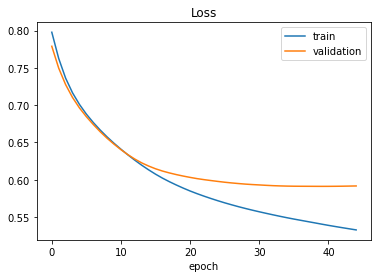

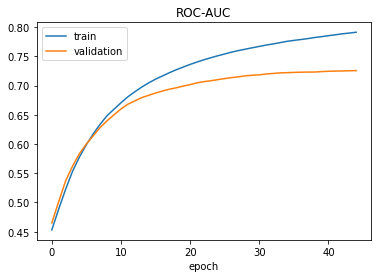

In [25]:
# Loss
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("Loss")
plt.show()

# ROC-AUC
plt.plot(hist.history["auc"], label="train")
plt.plot(hist.history["val_auc"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("ROC-AUC")
plt.show()

### Step 5: Evaluate the model performance

In [26]:
# Loss, Accuracy & ROC-AUC
model.evaluate(X_valid, y_valid)

44/44 [==============================] - 0s 2ms/step - loss: 0.5917 - acc: 0.6757 - auc: 0.7256


[0.5917451977729797, 0.6757143139839172, 0.7256353497505188]

### Step 6: Predict unseen data

In [27]:
# Generates output predictions for the input samples
model.predict(X_test).flatten()

78/78 [==============================] - 0s 2ms/step


array([0.5983922 , 0.14894284, 0.32919255, ..., 0.7445351 , 0.5807363 ,
       0.49491963], dtype=float32)

In [28]:
# Get class labels
np.where(model.predict(X_test) > 0.5, 1, 0).flatten()

78/78 [==============================] - 0s 2ms/step


array([1, 0, 0, ..., 1, 1, 0])

In [29]:
# Make submissions
t = pd.Timestamp.now()
fname = f"dnn_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
pd.DataFrame({'ID': ID_test, 'gender': model.predict(X_test).flatten()}).to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")

78/78 [==============================] - 0s 1ms/step
'dnn_submission_11252151.csv' is ready to submit.


###  Step 7: Save the model for future use

In [30]:
# pickle 형식으로 저장
# with open('nn_model.pkl', 'wb') as f:
#    pickle.dump(model, f)

# 추후 저장한 모형 불러올 때: 
# model = pd.read_pickle('nn_model.pkl')

In [31]:
# h5 형식으로 저장
# model.save('nn_model.h5')

# 추후 저장한 모형 불러올 때: 
# model = load_model('nn_model.h5')

<font color='tomato'><font color="#CC3D3D"><p>
# Automated Hyperparameter Tuning with Keras Tuner 
https://www.tensorflow.org/tutorials/keras/keras_tuner?hl=ko 

In [32]:
# keras tuner 설치
#!pip install -q -U keras-tuner
import kerastuner as kt

### Step 1 : Load the Data

In [34]:
# 앞 단계(Feature Enginnering)에서 저장했던 훈련/평가/적용 데이터를 읽어온다.
# 아래과 같이 pickle 형식으로 저장하였음:

# with open('preprocessed_data.pkl', 'wb') as f:
#     pickle.dump((X_train, y_train, X_valid, y_valid, X_test, ID_Test), f)

X_train, y_train, X_valid, y_valid, X_test, ID_test = pd.read_pickle('./data/preprocessed_data.pkl')

# 모델링에 사용되는 최종 학습 및 평가 데이터 확인
X_train.shape, X_valid.shape, X_test.shape

((2100, 147), (1400, 147), (2482, 147))

### Step 2 : Define the hyper-model

In [35]:
def model_fn(hp):
    inputs = keras.Input(shape=(X_train.shape[1],))
    x = keras.layers.Dense(hp.Int('unit', 8, 16, step=8), hp.Choice('activation', ['relu', 'elu']))(inputs)
    x = keras.layers.Dropout(hp.Float('dropout', 0, 0.25, step=0.25, default=0.25))(x)
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3])), 
                  metrics=[keras.metrics.AUC()])
    return model

In [ ]:
"""
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hps)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),]
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                 batch_size=1024, epochs=50, callbacks=callbacks, shuffle=False, verbose=2)

# Loss
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("Loss")
plt.show()
"""

### Step 3 : Perform the hyper-tuning

In [37]:
tuner = kt.Hyperband(model_fn,
                     objective=kt.Objective('val_auc', direction="max"), 
                     max_epochs=5,
                     hyperband_iterations=2,
                     overwrite=True,
                     directory='dnn_tuning')

tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), 
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Trial 19 Complete [00h 00m 03s]
val_auc: 0.7252895832061768

Best val_auc So Far: 0.7334313988685608
Total elapsed time: 00h 00m 43s
INFO:tensorflow:Oracle triggered exit


### Step 4 : Build the model
#### Get the best model

In [38]:
model = tuner.get_best_models(1)[0]
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 147)]             0         
                                                                 
 dense (Dense)               (None, 16)                2368      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,385
Trainable params: 2,385
Non-trainable params: 0
_________________________________________________________________


In [39]:
tuner.results_summary(1)

Results summary
Results in dnn_tuning\untitled_project
Showing 1 best trials
Trial summary
Hyperparameters:
unit: 16
activation: relu
dropout: 0.0
learning_rate: 0.01
tuner/epochs: 5
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.7334313988685608


#### Build the model with the optimal hyperparameters and train it on data

In [ ]:
"""
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hps)

callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),]
hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
                 batch_size=1024, epochs=50, callbacks=callbacks, shuffle=False, verbose=2)

# Loss
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="validation")
plt.legend()
plt.xlabel('epoch')
plt.title("Loss")
plt.show()
"""

### Step 5 : Make a Submission

In [ ]:
t = pd.Timestamp.now()
fname = f"dnn_tuned_submission_{t.month:02}{t.day:02}{t.hour:02}{t.minute:02}.csv"
pd.DataFrame({'ID': ID_test, 'gender': model.predict(X_test).flatten()}).to_csv(fname, index=False)
print(f"'{fname}' is ready to submit.")